In [1]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import os

from pyspark.ml.linalg import DenseVector
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType,FloatType,IntegerType,StructType
spark=SparkSession.builder.master("local").appName("大数据大作业-探索、填补缺失值").getOrCreate()

from pyspark.ml import feature as ft
# Enable Arrow support.
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "64")
# 搭一个spark的环境
sc=spark.sparkContext
sc

<SparkContext master=local appName=大数据大作业-探索、填补缺失值>

In [2]:
df_train=spark.read.csv("data.csv",header=True)
# 把那些特征变成应有的类型
for column in df_train.columns[1:-1]:
    df_train=df_train.withColumn(column,df_train[column].cast(FloatType()))
column="product_id"
df_train=df_train.withColumn(column,df_train[column].cast(IntegerType()))
df_train.printSchema()


root
 |-- product_id: integer (nullable = true)
 |-- product_category: float (nullable = true)
 |-- brand: float (nullable = true)
 |-- price: float (nullable = true)
 |-- quantity: float (nullable = true)
 |-- favorite: float (nullable = true)
 |-- negative_info: float (nullable = true)
 |-- image_url: string (nullable = true)



In [3]:
df_test=spark.read.csv("test.csv",header=True)
# 把那些特征变成应有的类型
for column in df_test.columns[1:-1]:
    df_test=df_test.withColumn(column,df_test[column].cast(FloatType()))
column="product_id"
df_test=df_test.withColumn(column,df_test[column].cast(IntegerType()))
df_test.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_category: float (nullable = true)
 |-- brand: float (nullable = true)
 |-- price: float (nullable = true)
 |-- quantity: float (nullable = true)
 |-- favorite: float (nullable = true)
 |-- negative_info: float (nullable = true)
 |-- image_url: string (nullable = true)



## 单变量探索性分析
* price分析

In [4]:
print('Count of rows: {0}'.format(df_train.count()))
print('Count of distinct rows: {0}'.format(df_train.distinct().count()))

Count of rows: 8000
Count of distinct rows: 8000


In [5]:
print('Count of rows: {0}'.format(df_test.count()))
print('Count of distinct rows: {0}'.format(df_test.distinct().count()))

Count of rows: 2000
Count of distinct rows: 2000


In [6]:
# 观察缺失数据
missing=df_train.rdd.map(
    lambda row: (row['product_id'], sum([c == None for c in row]))
).collect()

In [7]:
import pyspark.sql.functions as fn
data_missing_columns=df_train.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_train.columns
]).toPandas()
data_missing_columns

,product_id_missing,product_category_missing,brand_missing,price_missing,quantity_missing,favorite_missing,negative_info_missing,image_url_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 观察缺失数据
missing=df_test.rdd.map(
    lambda row: (row['product_id'], sum([c == None for c in row]))
).collect()

In [9]:
import pyspark.sql.functions as fn
test_missing_columns=df_test.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_test.columns
]).toPandas()
test_missing_columns

,product_id_missing,product_category_missing,brand_missing,price_missing,quantity_missing,favorite_missing,negative_info_missing,image_url_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-bright")
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False  

In [11]:
def plot_hist(column_name):
    """绘制hist的函数，输入是一个列名，需要输出的标题，来看看有什么模式可以应用"""
    
    hists=df_train.select(column_name).dropna().rdd.flatMap(lambda row: row).collect()
    if len(hists)==0:
        print(column_name,"没有数据，无法计算频数直方图")
        return 
    fig = plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.hist(hists)
    ax.set_title(column_name+'频数直方图')
    plt.show();

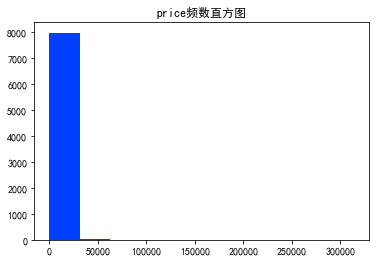

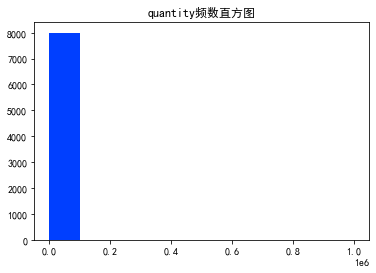

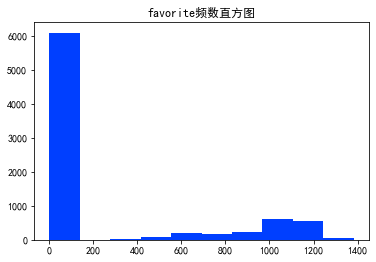

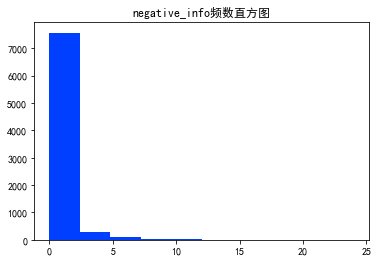

In [12]:
for column in df_train.columns[3:7]:
    plot_hist(column)

In [13]:
def plot_hist(column_name):
    """绘制hist的函数，输入是一个列名，需要输出的标题，来看看有什么模式可以应用"""
    
    hists=df_test.select(column_name).dropna().rdd.flatMap(lambda row: row).collect()
    if len(hists)==0:
        print(column_name,"没有数据，无法计算频数直方图")
        return 
    fig = plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.hist(hists)
    ax.set_title(column_name+'频数直方图')
    plt.show();

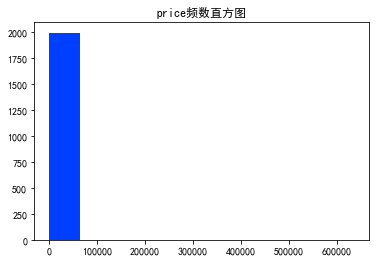

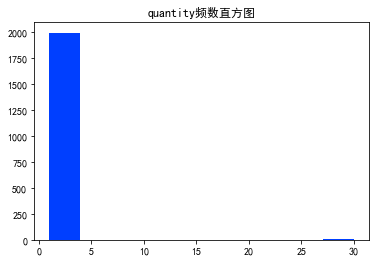

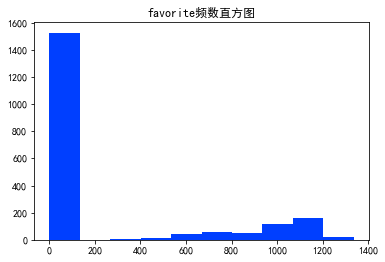

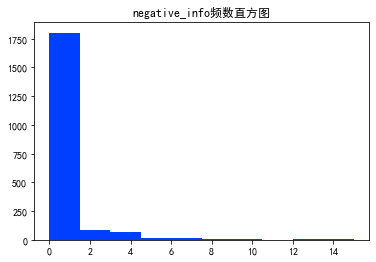

In [14]:
for column in df_test.columns[3:7]:
    plot_hist(column)

In [15]:
train=df_train.toPandas()
train=train.drop("image_url",axis=1)
test=df_test.toPandas()
test=test.drop("image_url",axis=1)

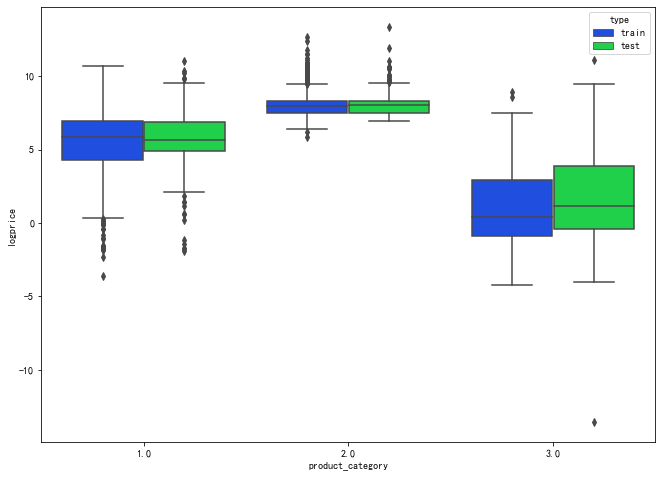

In [16]:
# 箱线图
# 为了结果更加清楚，这里临时对dataprice取log
import seaborn as sns
train["logprice"]=np.log(train["price"])
test["logprice"]=np.log(test["price"])
train["type"]="train"
test["type"]="test"
data=train.append(test)
plt.figure(figsize=(11,8))
sns.boxplot(data=data,x="product_category",y="logprice",hue="type");
plt.show();

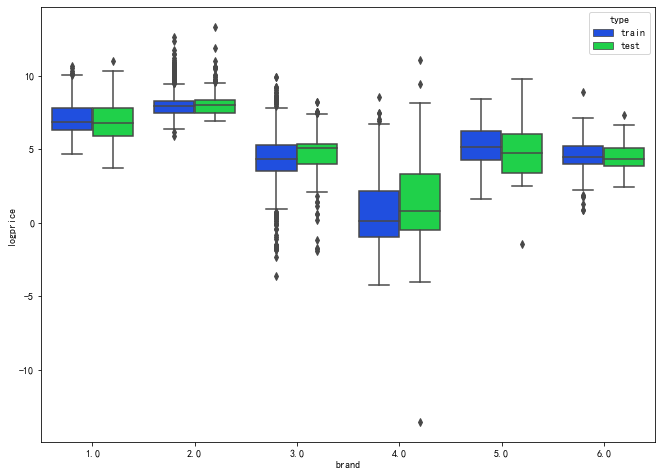

In [17]:
plt.figure(figsize=(11,8))
sns.boxplot(data=data,x="brand",y="logprice",hue="type");
plt.show();

In [18]:
from sklearn.preprocessing import OneHotEncoder
def onehot(name,train=train,test=test):
    clf=OneHotEncoder(sparse=False)
    clf.fit(train.loc[:,name].to_numpy().reshape(-1,1))
    res_train=clf.transform(train.loc[:,name].to_numpy().reshape(-1,1))   
    res_test=clf.transform(test.loc[:,name].to_numpy().reshape(-1,1))
    new_columns=[name+str(i) for i in range(0,res_train.shape[1])]
    train.loc[:,new_columns]=res_train
    test.loc[:,new_columns]=res_test
    train=train.drop(name,axis=1)
    test=test.drop(name,axis=1)
    return (train,test)

train,test=onehot("product_category")
train,test=onehot("brand")
data=train.append(test,ignore_index=True)

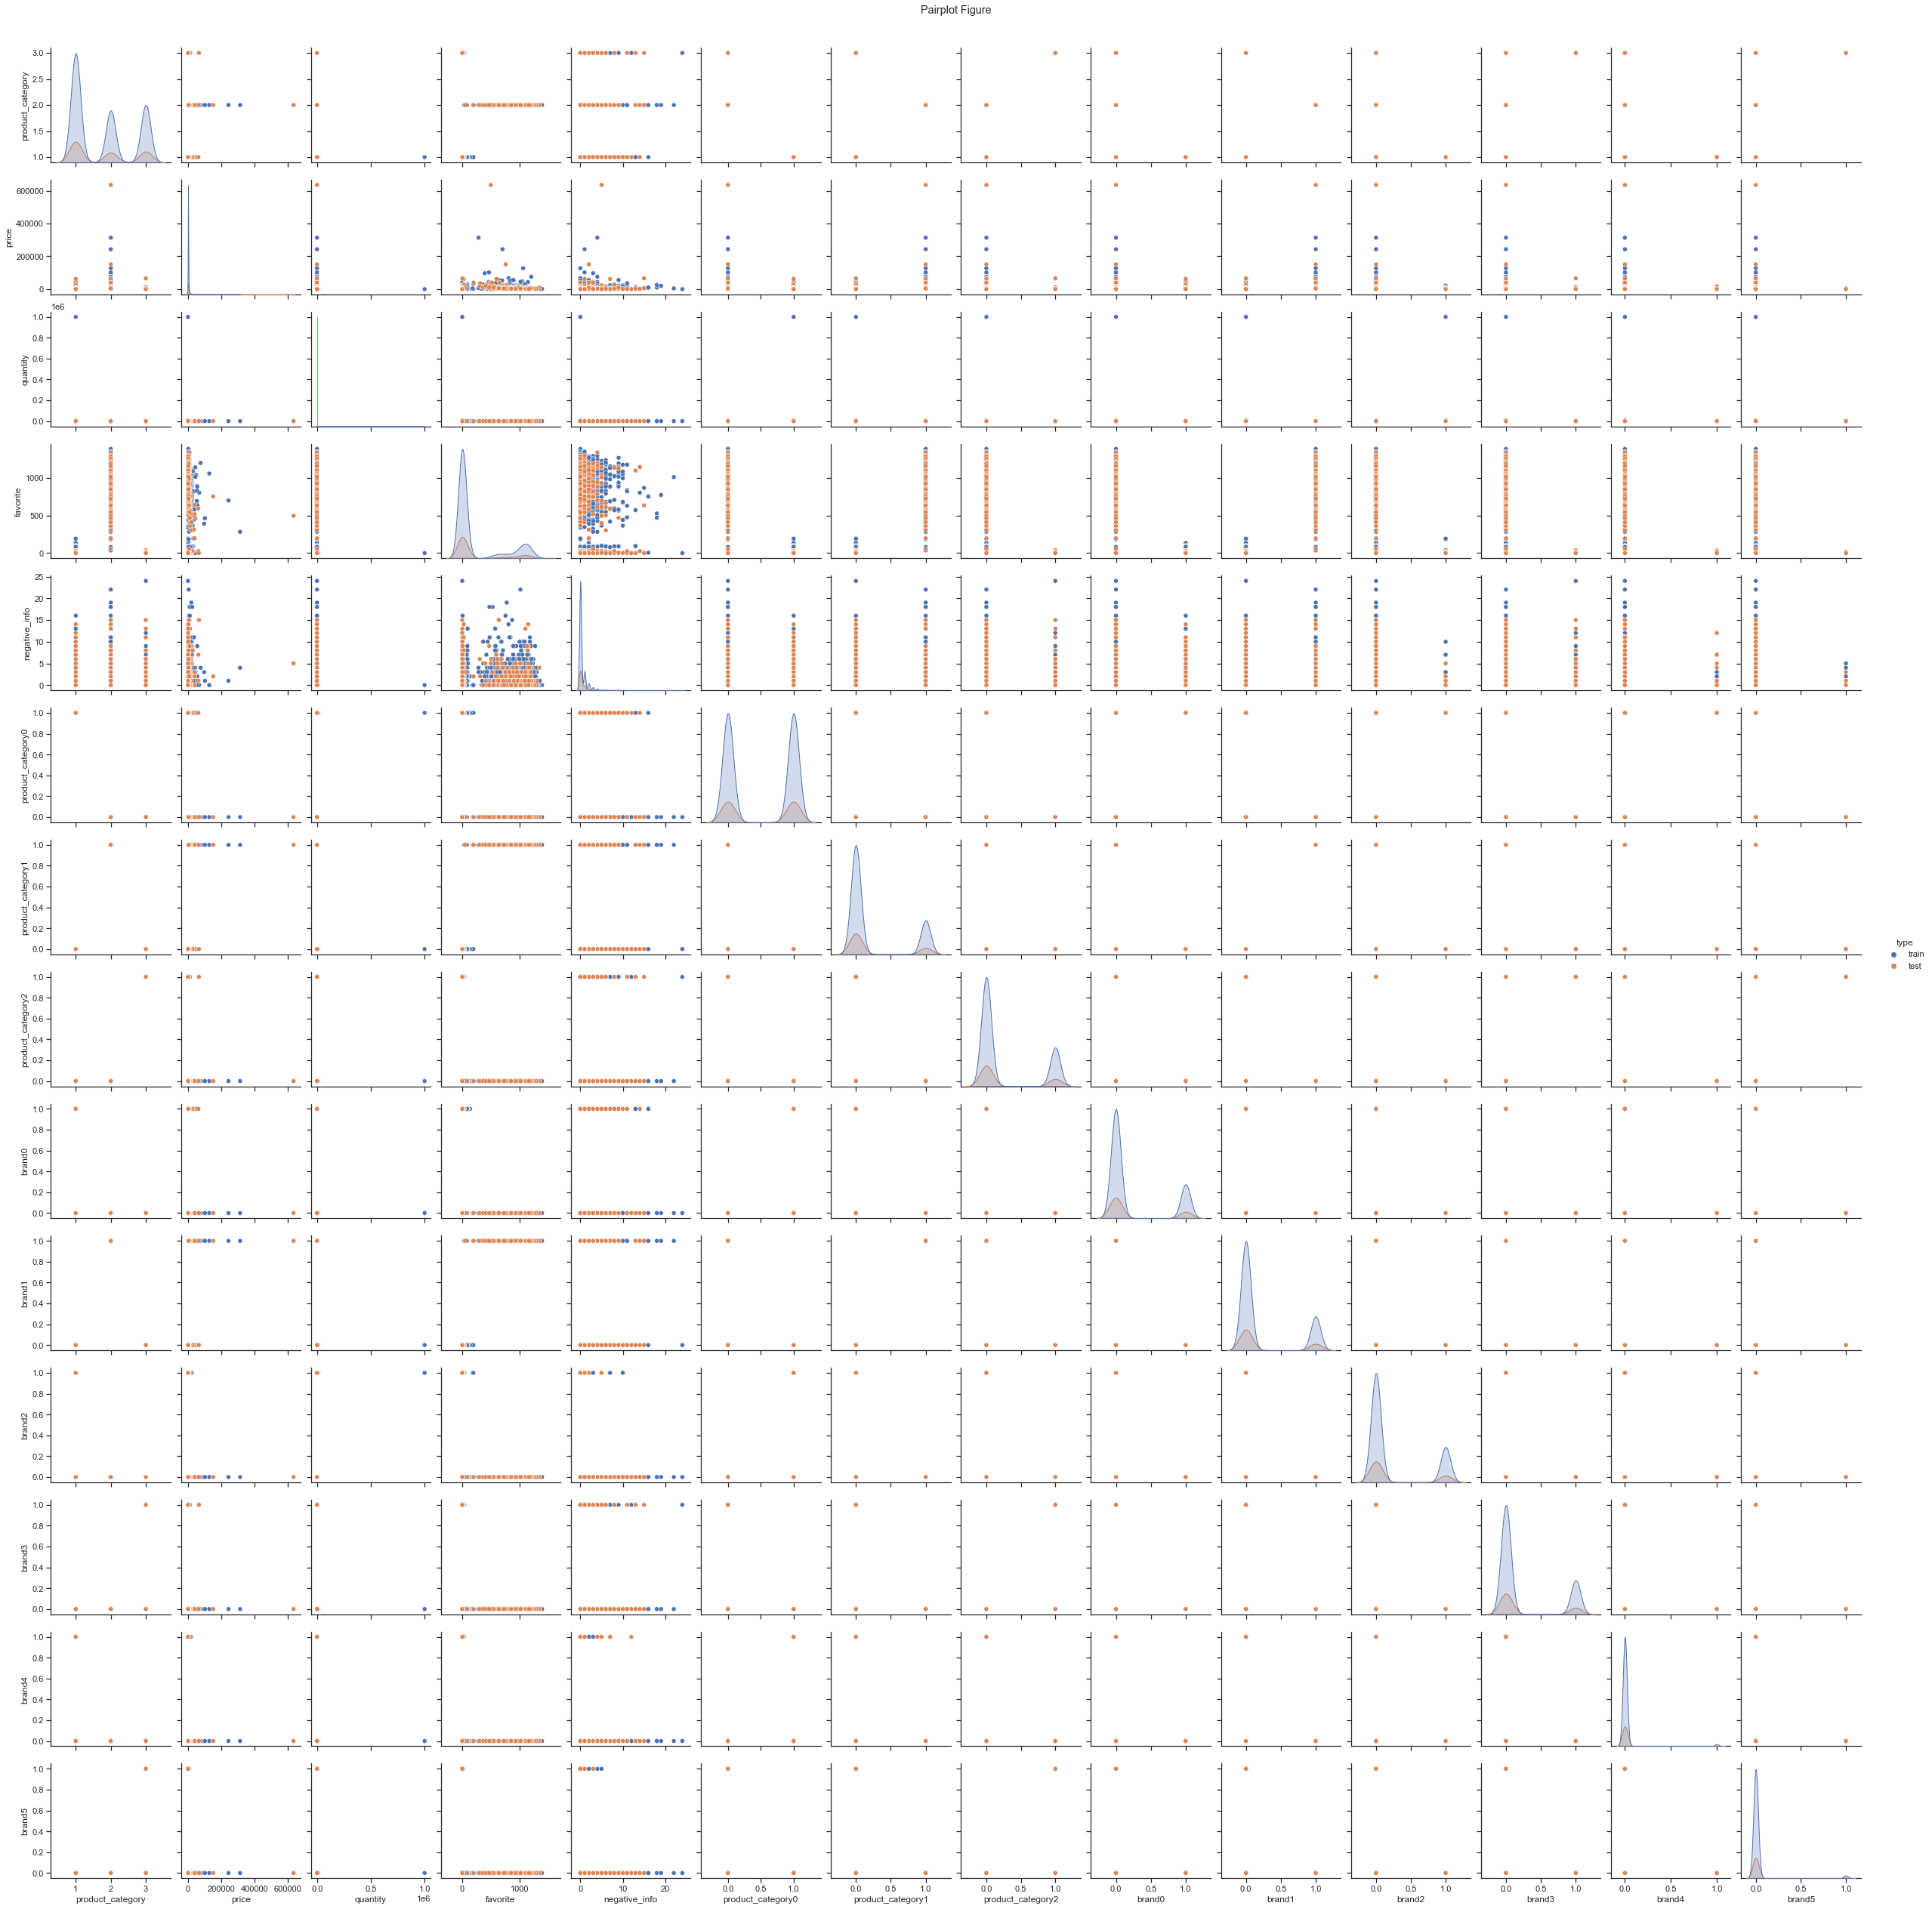

In [19]:
sns.set_theme(style="ticks")
sns.color_palette("tab10")
figure=sns.pairplot(data.loc[:,[column for column in data.columns if column!="logprice" and column!="product_id"]],hue="type")
figure.fig.suptitle("Pairplot Figure", y=1.01);

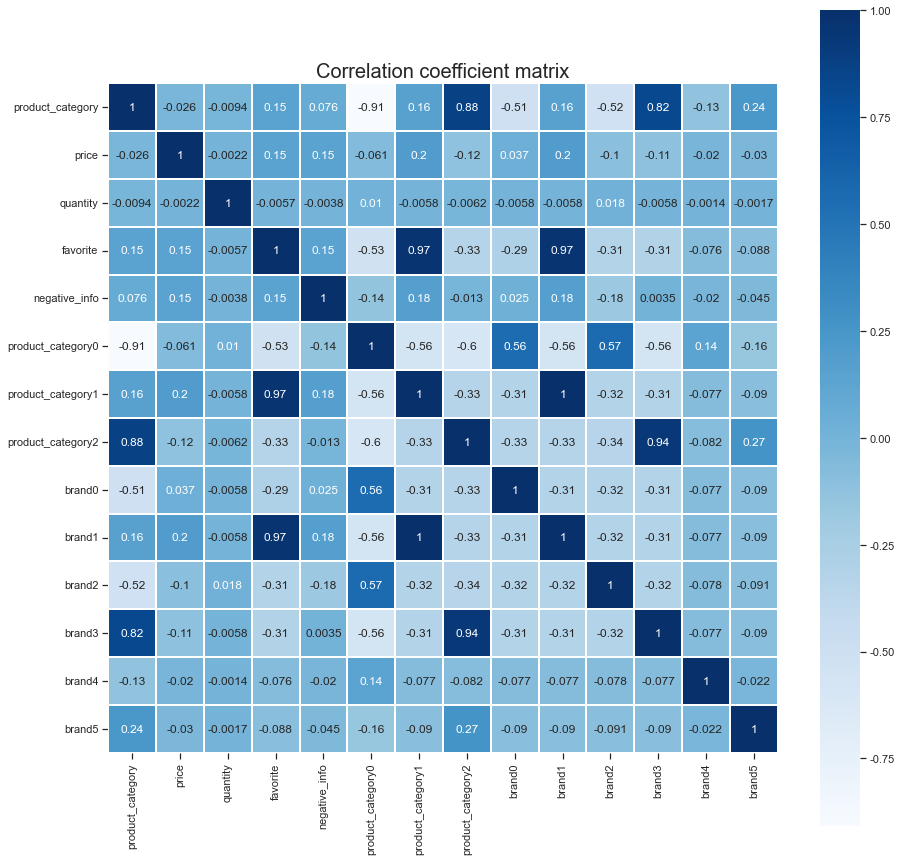

In [20]:
corr=data.loc[:,[column for column in data.columns if column!="logprice" and column!="product_id" and column!="type"]].corr()
plt.subplots(figsize=(15, 15))#创建子图
figure1=sns.heatmap(corr,annot=True, vmax=1, linewidths=.2,square=True, cmap="Blues")
#使用heatmap创建热图
figure1.set_title("Correlation coefficient matrix",
                  fontdict={'weight':'normal','size': 20});